# Projet 4 : Classification et Prédiction

## Importer les librairies et le dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_excel("Dataset1_ HR-EmployeeAttrition.xlsx")
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41.0,Yes,Travel_Rarely,1102.0,Sales,1.0,2.0,Life Sciences,1.0,1.0,...,1.0,80.0,0.0,8.0,0.0,1.0,6.0,4.0,0.0,5.0
1,49.0,No,Travel_Frequently,279.0,Research & Development,8.0,1.0,Life Sciences,1.0,2.0,...,4.0,80.0,1.0,10.0,3.0,3.0,10.0,7.0,1.0,7.0
2,37.0,Yes,Travel_Rarely,1373.0,Research & Development,2.0,2.0,Other,1.0,4.0,...,2.0,80.0,0.0,7.0,3.0,3.0,0.0,0.0,0.0,0.0
3,33.0,No,Travel_Frequently,1392.0,Research & Development,3.0,4.0,Life Sciences,1.0,5.0,...,3.0,80.0,0.0,8.0,3.0,3.0,8.0,7.0,3.0,0.0
4,27.0,No,Travel_Rarely,591.0,Research & Development,2.0,1.0,Medical,1.0,7.0,...,4.0,80.0,1.0,6.0,3.0,3.0,2.0,2.0,2.0,2.0


## Pretraitement du dataset

### Codification

In [3]:
df["BusinessTravel"] = df["BusinessTravel"].astype('category')
df["Attrition"] = df["Attrition"].astype('category')
df["Gender"] = df["Gender"].astype('category')

df["BusinessTravel"] = df["BusinessTravel"].cat.codes
df["Attrition"] = df["Attrition"].cat.codes
df["Gender"] = df["Gender"].cat.codes

df[["BusinessTravel","Attrition", "Gender"]].head()

,BusinessTravel,Attrition,Gender
0,2,1,0
1,1,0,1
2,2,1,1
3,1,0,0
4,2,0,1


### Traitement des valeurs manquantes

In [4]:
def moyenne(df, d):
    return float("{:.2f}".format(df[d].sum() / df[d].count()))

def median(df, d): 
    colonne_sorted = list(df[d].sort_values())
    n = len(df[d])
    return ((colonne_sorted[n//2] + colonne_sorted[n//2 + 1]) / 2) if n % 2 == 0 else colonne_sorted[(n+1)/2]

def mode(df, d):
    l = []
    l.append(df[d].value_counts().index)
    l.append(list(df[d].value_counts()))
    mod = [l[0][0]]
    for i in range(1, len(l[0])):
        if l[1][i] == l[1][0]:
            mod.append(l[0][i])
        else:
            break
    return mod if len(mod) > 1 else [] if len(mod) == len(df[d]) else mod[0]

In [5]:
df[df.columns[df.isnull().any()]].isnull().sum()

EnvironmentSatisfaction    13
MonthlyIncome               8
dtype: int64

In [6]:
df['MonthlyIncome'].replace(np.nan, median(df,'MonthlyIncome'), inplace=True) 
df['EnvironmentSatisfaction'].replace(np.nan, mode(df,'EnvironmentSatisfaction'), inplace=True)
df[df.columns[df.isnull().any()]].isnull().sum()

Series([], dtype: float64)

### Valeurs aberrantes

In [7]:
def ecart_moyen(df, d):
    em = []
    m = moyenne(df, d)
    for d in df[d]:
        em.append(float("{:.2f}".format(np.abs(d-m))))
    return em

def variance(df, d):
    em_sum = []
    m = moyenne(df, d)
    n = len(df[d])
    for d in df[d]:
        em_sum.append(np.power((d - m), 2))
    return float("{:.2f}".format(sum(em_sum) / n))

def ecart_type(var):
    return float("{:.2f}".format(np.sqrt(var)))

def quartilles(df, d):
    colonne_sorted = list(df[d].sort_values())
    n = len(df[d])
    return [min(colonne_sorted), colonne_sorted[n // 4], colonne_sorted[(n * 3) // 4], max(colonne_sorted)]

def iqr(quart):
    return quart[2] - quart[1] 

In [8]:
from pandas.api.types import is_numeric_dtype
from math import log10

def get_outliers(df, columns_info):
    mesures_de_dispersion = {}
    for ci in columns_info:
        d, method = ci
        outs = {}
        mdd = {}
        if is_numeric_dtype(df[d]):
            em = ecart_moyen(df, d)
            quart = quartilles(df, d)
            quart_name = ["Minimum", "Q1", "Q3", "Maximum"]
            for q, qm in zip(quart, quart_name):
                mdd[qm] = q
            mdd["IQR"] = iqr(quart)
            Outliers = [x for x in df[d] if (x > (mdd["Q3"] + 1.5 * mdd["IQR"])) or (x < (mdd["Q1"] - 1.5 * mdd["IQR"]))]
            outs["Donnees aberanttes"] = "Aucune" if len(Outliers) == 0 else set(Outliers)
            mesures_de_dispersion[d] = outs
    return pd.DataFrame.from_dict(mesures_de_dispersion, orient='index')

def replace_outliers(df, columns_info):
    mesures_de_dispersion = {}
    for ci in columns_info:
        d, method = ci
        mdd = {}
        if is_numeric_dtype(df[d]):
            quart = quartilles(df, d)
            quart_name = ["Minimum", "Q1", "Q3", "Maximum"]
            for q, qm in zip(quart, quart_name):
                mdd[qm] = q
            mdd["IQR"] = iqr(quart)
            df.loc[(df[d] > (mdd["Q3"] + 1.5 * mdd["IQR"])), d] = np.nan
            df.loc[(df[d] < (mdd["Q1"] - 1.5 * mdd["IQR"])), d] = np.nan
            if method == "m":
                med = median(df, d)
                df.fillna(med, inplace=True)
            elif method == "k":
                k = 1 + (10 / 3) * log10(len(df[d]))
                val = (mdd["Maximum"] - mdd["Minimum"]) / k
                df.fillna(val, inplace=True)
            else:
                df.fillna(mdd["IQR"], inplace=True)
    return df

In [9]:
columns = [("MonthlyIncome", "k"), ("PerformanceRating", "m"), ("StockOptionLevel", "m"), ("TotalWorkingYears", "k"), ("YearsWithCurrManager", "iqr")]
outliers = get_outliers(df,columns)
outliers

,Donnees aberanttes
MonthlyIncome,"{18947.0, 17924.0, 19973.0, 17426.0, 19999.0, ..."
PerformanceRating,{4.0}
StockOptionLevel,{3.0}
TotalWorkingYears,"{32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 40...."
YearsWithCurrManager,"{16.0, 17.0, 15.0}"


In [10]:
while (outliers['Donnees aberanttes'] != "Aucune").any():
    df = replace_outliers(df,columns)
    outliers = get_outliers(df,columns)
outliers

,Donnees aberanttes
MonthlyIncome,Aucune
PerformanceRating,Aucune
StockOptionLevel,Aucune
TotalWorkingYears,Aucune
YearsWithCurrManager,Aucune


### Discrétisation

In [11]:
def discretisation_intervalle_egal(df):
    col = []
    for d in df:
        mdd = {}
        if is_numeric_dtype(df[d]) and d not in ["BusinessTravel","Attrition","Gender"]:
            col.append(d)
            k = int(1 + (10 / 3) * log10(len(df[d]))) + 1
            quart = quartilles(df, d)
            quart_name = ["Minimum", "Q1", "Q3", "Maximum"]
            for q, qm in zip(quart, quart_name):
                mdd[qm] = q
            largeur = (mdd["Maximum"] - mdd["Minimum"]) / k
            categories = []
            val_min_intervalle = mdd["Minimum"]
            val_max_intervalle = mdd["Minimum"] + largeur
            for i in range(k):
                categories.append((val_min_intervalle, val_max_intervalle))
                val_min_intervalle = val_max_intervalle;
                val_max_intervalle += largeur;
            indice = -1
            for cat in categories:
                df.loc[(cat[0] <= df[d]) & (df[d] < cat[1]), d] = indice
                indice -= 1
            indice = -1
            for cat in categories:
                df.loc[df[d] == indice, d] = "["+str(int(cat[0]))+", "+str(int(cat[1]))+"["
                indice -= 1
    return df, col

import matplotlib
def make_plots(X, cols):
    for d in cols:   
        fig, axes = plt.subplots(1,1)
        sns.countplot(x=X[d], ax= axes)
        axes.set_xticklabels(labels=X[d].unique(),rotation=90)
        plt.show()

In [12]:
df_discretise = df.copy()
df_discretise, cols = discretisation_intervalle_egal(df_discretise)
df_discretise.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,"[39, 42[",1,2,"[1033, 1149[",Sales,"[1, 3[","[1, 2[",Life Sciences,1.0,"[1, 173[",...,"[1, 1[",80.0,"[0, 0[","[7, 8[","[0, 0[","[1, 1[","[3, 6[","[3, 4[","[0, 1[","[4, 5["
1,"[46, 49[",0,1,"[218, 334[",Research & Development,"[8, 10[","[1, 1[",Life Sciences,1.0,"[1, 173[",...,4.0,80.0,"[0, 1[","[8, 10[","[3, 3[","[3, 3[","[10, 13[","[6, 7[","[0, 1[","[5, 7["
2,"[35, 39[",1,2,"[1266, 1382[",Research & Development,"[1, 3[","[1, 2[",Other,1.0,"[1, 173[",...,"[2, 2[",80.0,"[0, 0[","[7, 8[","[3, 3[","[3, 3[","[0, 3[","[0, 1[","[0, 1[","[0, 1["
3,"[32, 35[",0,1,"[1382, 1499[",Research & Development,"[1, 3[","[4, 4[",Life Sciences,1.0,"[1, 173[",...,"[3, 3[",80.0,"[0, 0[","[7, 8[","[3, 3[","[3, 3[","[6, 10[","[6, 7[","[2, 3[","[0, 1["
4,"[25, 28[",0,2,"[567, 684[",Research & Development,"[1, 3[","[1, 1[",Medical,1.0,"[1, 173[",...,4.0,80.0,"[0, 1[","[5, 7[","[3, 3[","[3, 3[","[0, 3[","[1, 3[","[1, 2[","[1, 2["


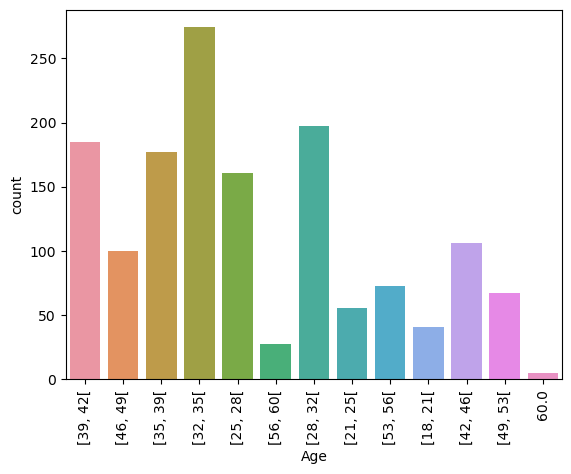

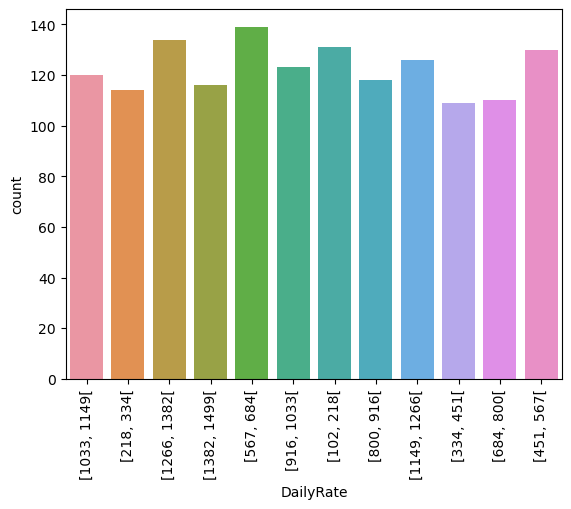

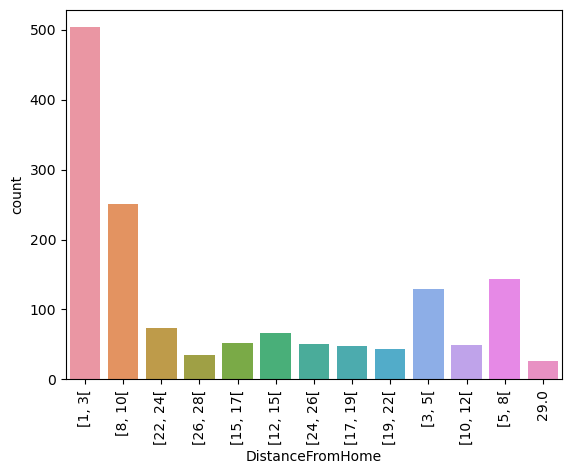

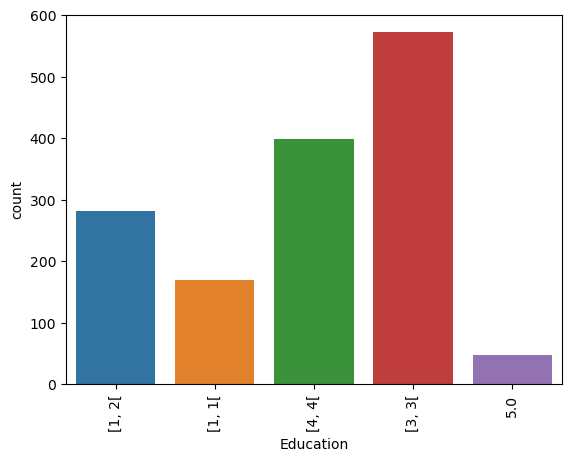

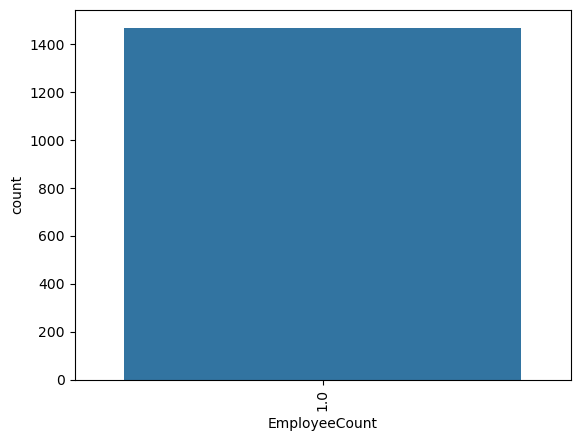

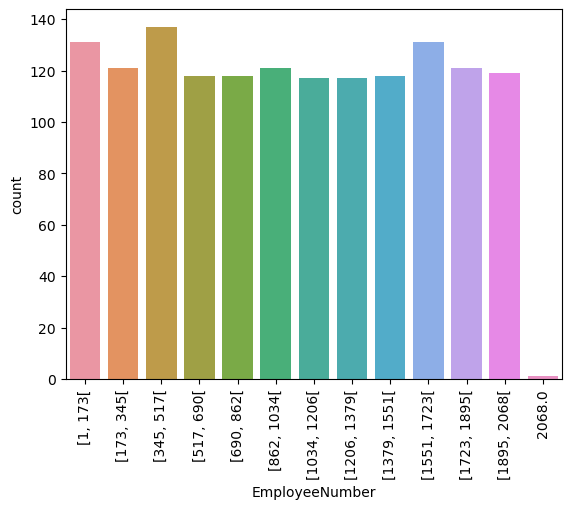

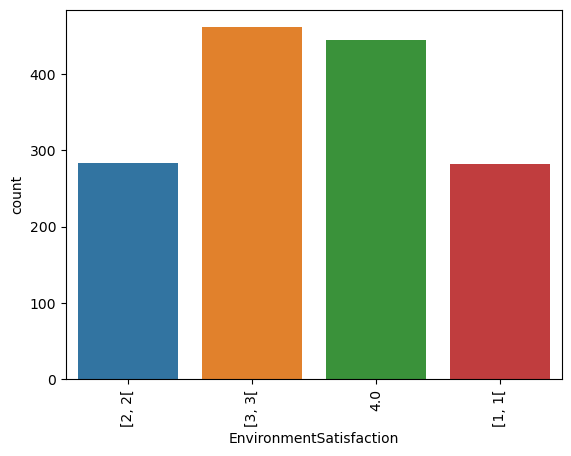

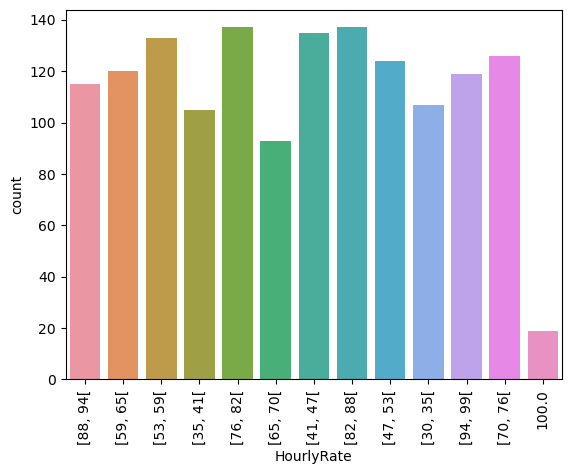

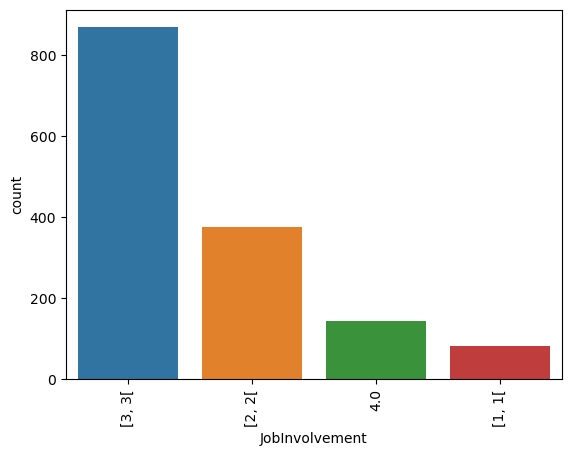

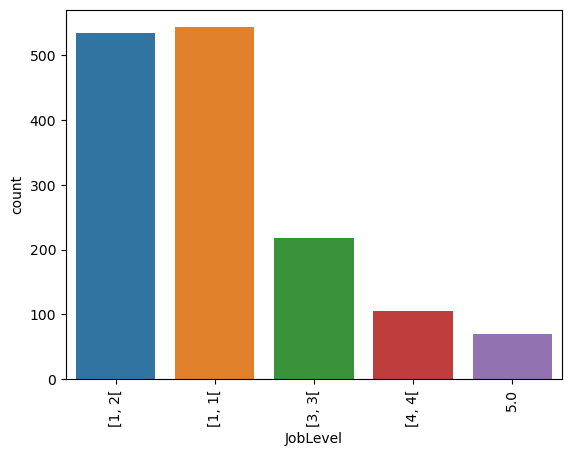

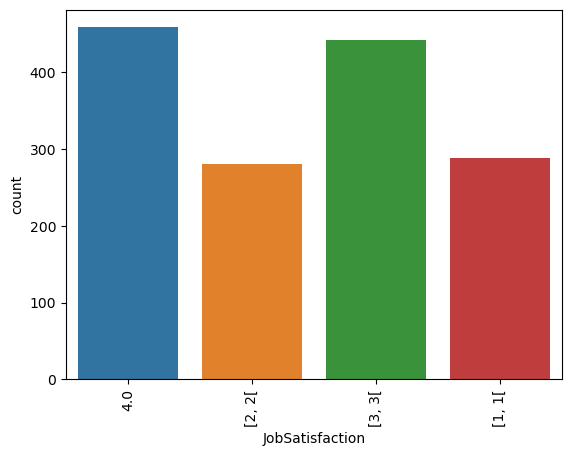

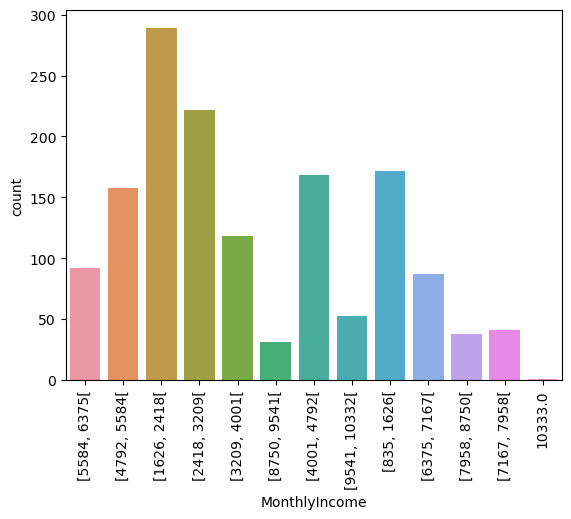

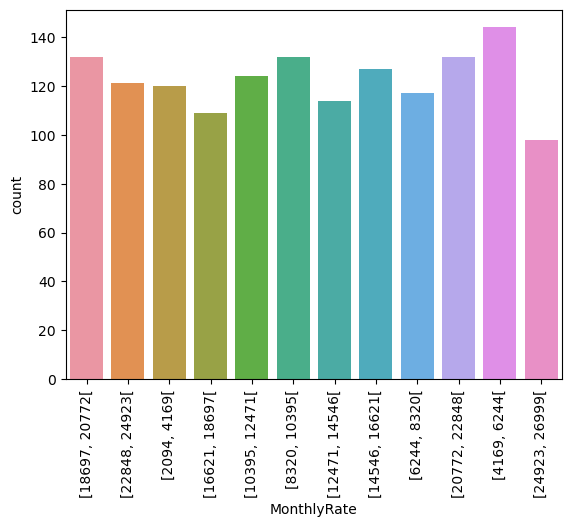

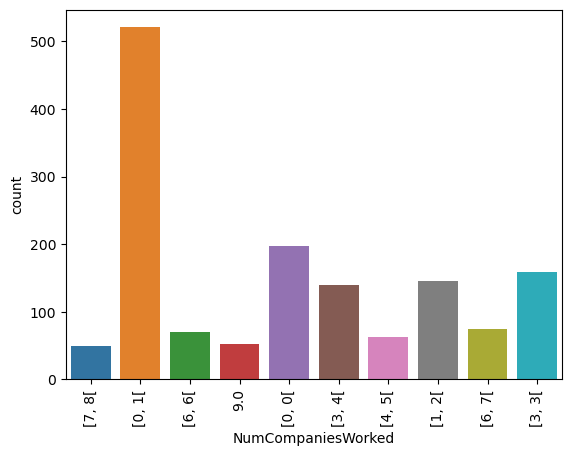

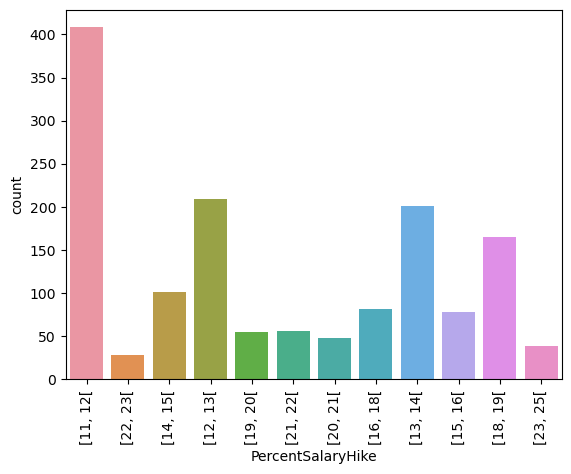

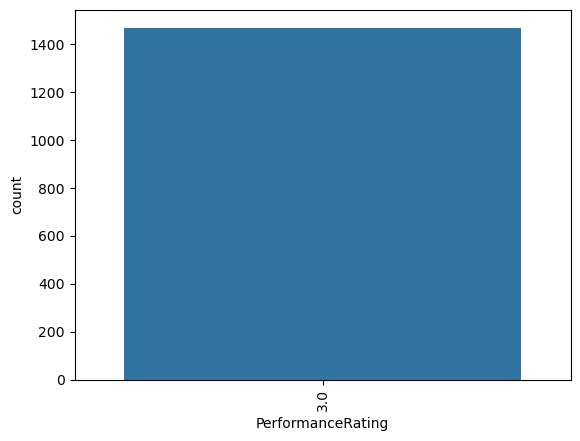

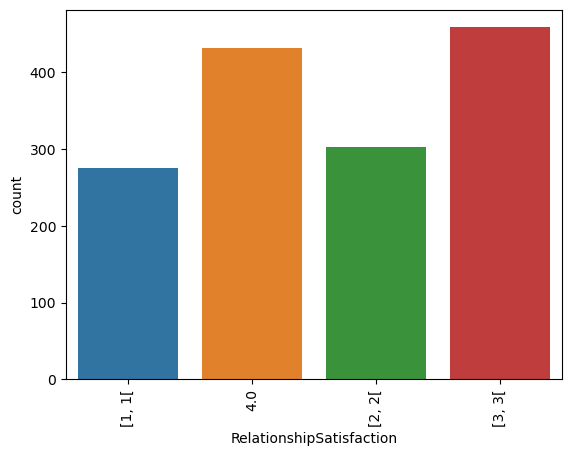

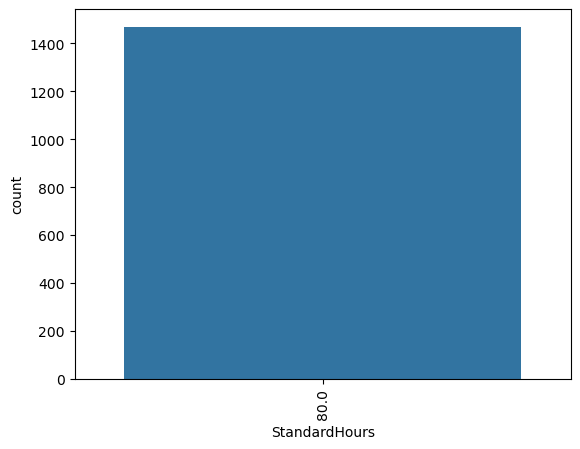

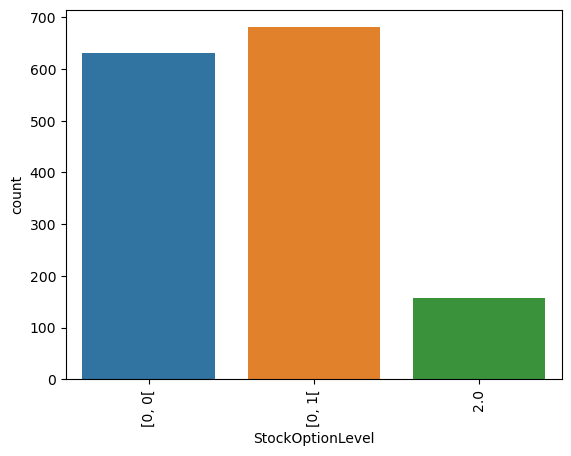

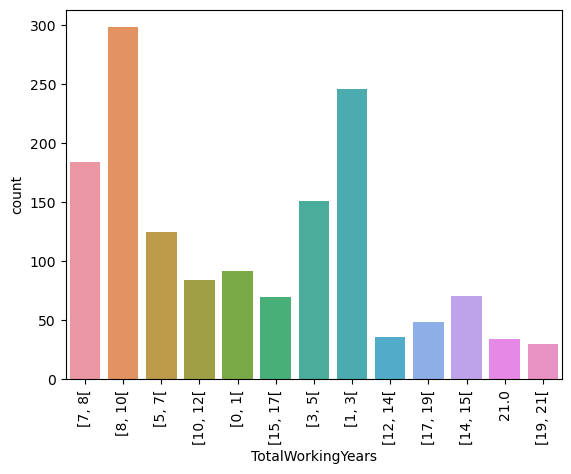

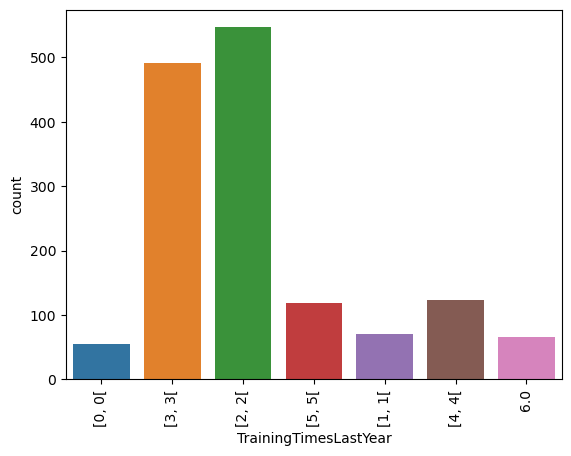

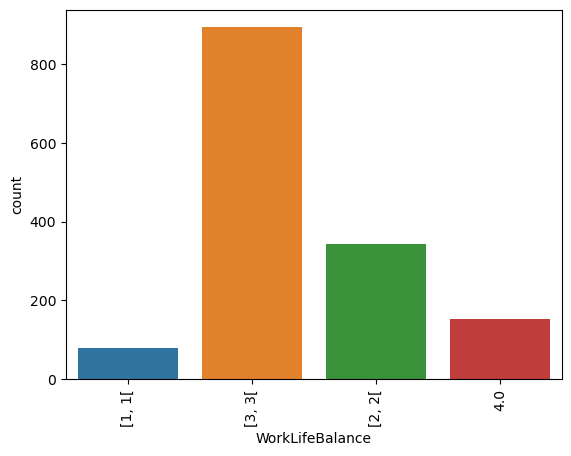

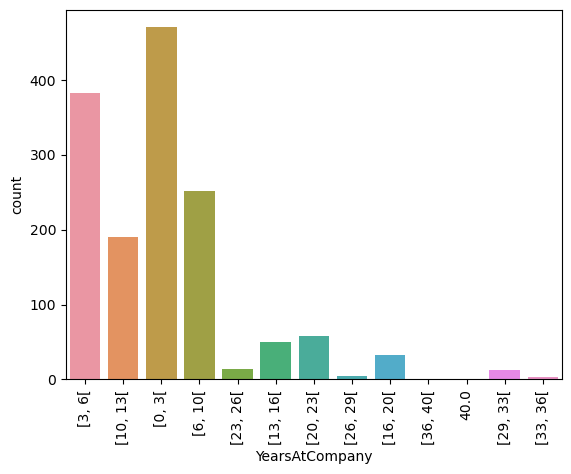

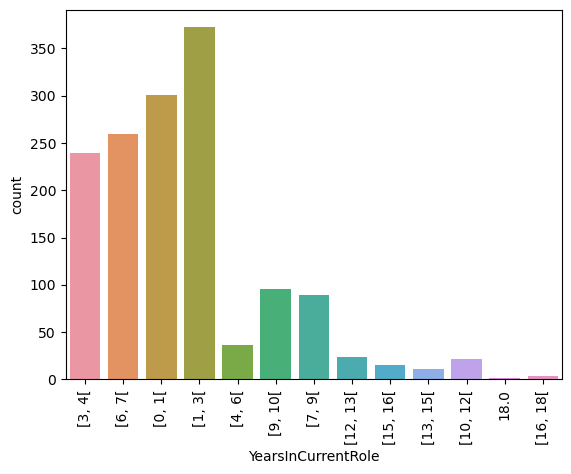

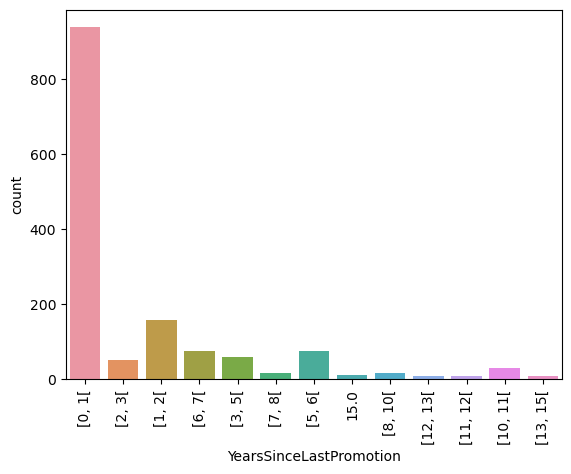

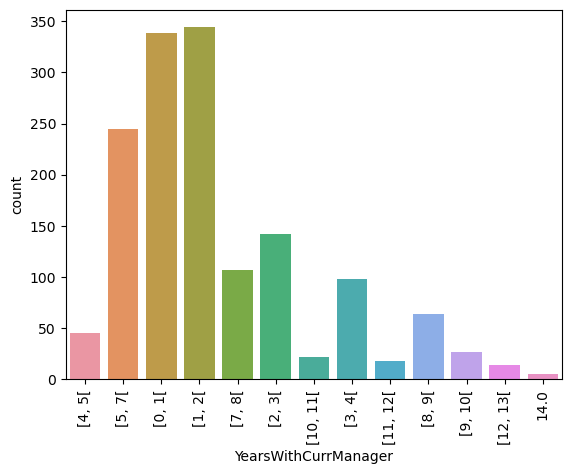

In [13]:
make_plots(df_discretise, cols)

### Réduction des dimentionalité V

In [14]:
df.drop(['EmployeeCount', 'Over18', 'StandardHours', 'PerformanceRating','EmployeeNumber'], axis=1, inplace=True)

### Réduction des dimentionalité H

In [15]:
df = df.loc[df_discretise["YearsWithCurrManager"] != 14.0]
df = df.loc[df_discretise["YearsSinceLastPromotion"] != 15.0]
df = df.loc[df_discretise["YearsInCurrentRole"] != 18.0]
df = df.loc[df_discretise["YearsAtCompany"] != 40.0]
df = df.loc[df_discretise["TotalWorkingYears"] != 21.0]
df = df.loc[df_discretise["NumCompaniesWorked"] != 9.0]
df = df.loc[df_discretise["MonthlyIncome"] != 10333.0]
df = df.loc[df_discretise["HourlyRate"] != 100.0]
df = df.loc[df_discretise["EmployeeNumber"] != 2068.0]
df = df.loc[df_discretise["DistanceFromHome"] != 29.0]
df = df.loc[df_discretise["Age"] != 60.0]

### Normalisation

In [16]:
def minmax(df):
    for d in df.columns:
        if is_numeric_dtype(df[d]) and d not in ["BusinessTravel","Attrition","Gender"]:
            col_values = df[d].to_numpy()
            value_min = col_values.min()
            value_max = col_values.max()
            df[d] =  ((df[d] - value_min) / (value_max - value_min))*(1-0)+0
    return df

In [17]:
minmax(df)
df = df.round(2)
df

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,0.56,1,2,0.72,Sales,0.00,0.25,Life Sciences,0.33,0,...,0.00,0.00,0.0,0.40,0.00,0.00,0.16,0.24,0.00,0.38
1,0.76,0,1,0.13,Research & Development,0.26,0.00,Life Sciences,0.67,1,...,0.86,1.00,0.5,0.50,0.50,0.67,0.27,0.41,0.07,0.54
2,0.46,1,2,0.91,Research & Development,0.04,0.25,Other,1.00,1,...,0.29,0.33,0.0,0.35,0.50,0.67,0.00,0.00,0.00,0.00
3,0.37,0,1,0.92,Research & Development,0.07,0.75,Life Sciences,1.00,0,...,0.00,0.67,0.0,0.40,0.50,0.67,0.22,0.41,0.21,0.00
5,0.34,0,1,0.65,Research & Development,0.04,0.25,Life Sciences,1.00,1,...,0.14,0.67,0.0,0.40,0.33,0.33,0.19,0.41,0.21,0.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1464,0.20,0,2,0.76,Sales,0.15,0.50,Other,1.00,0,...,0.50,1.00,0.0,0.25,0.33,0.67,0.11,0.12,0.00,0.00
1465,0.44,0,1,0.56,Research & Development,0.81,0.25,Medical,0.67,1,...,0.43,0.67,0.5,0.85,0.50,0.67,0.14,0.12,0.00,0.23
1466,0.51,0,2,0.37,Research & Development,0.19,0.00,Medical,1.00,1,...,0.29,0.00,0.5,0.45,0.83,0.67,0.19,0.41,0.07,0.54
1467,0.22,0,2,0.04,Research & Development,0.11,0.50,Life Sciences,0.33,1,...,0.64,0.33,0.5,0.30,0.00,0.67,0.16,0.12,0.00,0.23


## Séparation du dataset en train et test set

## Random forest from scratch

## Decision tree from scratch

## Matrice de confusion

## Métriques